**Para execução deste tutorial é necessária a instalação de algumas dependências:**

1. [Savime](https://github.com/hllustosa/Savime/). Execute o script `examples/test_savime.sh` para verificar se a instalação foi bem sucedida.
2. Algumas bibliotecas em Python dispostas em `tutorial.yml`. A maneira mais fácil de as instalar é obter o gerenciador [Anaconda](https://www.anaconda.com/) e criar um ambiente com o seguinte comando:
    - `conda env create -f tutorial.yml`
    - Para ativar o ambiente basta executar `conda activate tutorial`
3. [PySavime](https://github.com/dnasc/PySavime): Utilize o ambiente criado anteriormente durante o processo de compilação; não será necessário efetuar a instalação dos pacotes sugeridos no repositório PySavime.
4. [TFX](https://www.tensorflow.org/tfx/serving/setup): No Ubuntu você deve executar `sudo apt install tensorflow-model-server`.

# Parte 01

Nesta para serão gerados múltiplos modelos (adaptação da [Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization)) . Esses serão utilizados posteriormente 
para se testar a capacidade do SAVIME corretamente invocar um modelo instanciado no Tensorflow Server.

Para isso, os seguintes passos serão executados nesse parte:

1. Definir o "fenômeno" sintético na forma $y = f(x)$, sendo $f$ a função alvo do
aprendizado. No caso, $x \in X \subseteq \mathbb{R}^d$ e $y \in  Y \subseteq 
\mathbb{R}$ onde $d$ é a quantidade de
*features* de $x$. Assim, o fenômeno a será modelado por um regressor.
2. Gerar uma amostra uniforme (dataset) $D_X \subset X$.
3. Produzir $D_Y$ a partir de $D_X$ e $D = concat(D_X, D_Y)$.
3. Treinar $m$ modelos (regressores) $m_i: X \to Y$. Cada modelo $m_i$ deve ser
treinado (treino / teste/ validação) em uma partição de $d_i \subset D$ tal que
$D = \bigcup_{i=1}^{m} d_i$ e $\bigcap_{i=1}^{m} d_i = \emptyset$. 
Em particular, se $i < j$ então $\forall x_i \in d_i^X, x_j \in d_j^X \left(x_i < x_j \right)$ onde
$d_i^X$ indica o conjunto de elementos $x \in d_i$. 
4. Utilizar uma métrica $\phi$ e avaliar cada modelo $m_i$ em cada partição $d_j$. 
No caso desse exemplo $\phi$ é o erro  quadrático médio entre a predição e o valor
verdadeiro.
5. Salvar os modelos em um formato adequado para execução posterior no tensorflow,
assim como $D$ em disco a fim de ser registrado no SAVIME.

## Definição do fenômeno sintético (função $f$):
- $X = [low, high]$ onde $low, high \in \mathbb{R}, low < high$ (e.g., $X = [-1, 1]$);
- $D_X = (x_1, ..., x_n), x_i \sim U(X)$, onde $n$ é o número de observações.
- $D_Y = (f(x),  x \in D_X)$.
- $D = (D_X, D_Y)$ é particionado em $m$ particões $d_i$ cada qual associada a um modelo $m_i$.
- $A = linspace(low=1, high=2, num\_partitions = m)$ é um vetor ordenado e igualmente 
espaçado de números entre 1 e 5 e de tamanho igual a $m$. Cada $d_i$ é associado com
um $\alpha_i \in A$.
- $g(x)$ indica qual o $\alpha$ deve ser associado a $x$. Por exemplo, se $X = [-1, 1]$,
e $m = 2$ então $A = [1, 5]$, $g(x=-.5) = 1$ e $g(x=.5) = 5$.
- $f(x) = g(x_1)x_1 + ... + g(x_d)x_d + \varepsilon$, onde
$\varepsilon \sim \mathcal{N}(\mu, \sigma)$ (e.g., $\mu = 0$ e $\sigma=1$). 
- *Note que $f$ é uma coletânea de funções lineares cada qual associada a uma partição de $X$.

In [1]:
import os
import random as rn

# Necessário mudar o diretório de trabalho para o nível mais acima
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from src.functions import f2_x
from src.model import ElasticNet, ModelFactory
from src.util import plot_heatmap

seed = 32
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Paired"))

tf.get_logger().setLevel('ERROR')
# my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
# tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

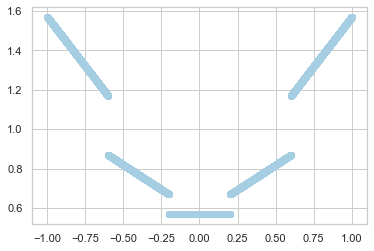

In [2]:
# Exemplo do comportamento de f
low_plot, high_plot, num_partitions_plot = -1, 1, 5
x_plot = np.random.uniform(low_plot, high_plot, 10000).reshape(-1, 1)
y_plot = f2_x(x_plot, low_plot, high_plot, num_partitions_plot, 0, 1,
              alpha_min=-1, alpha_max=1)
sns.regplot(x_plot.ravel(), y_plot.ravel(), fit_reg=False)

In [3]:
# número de features, observações e modelos
d = 2
n = 1000000
m = 20

# Input shape do modelo
input_shape = (d, )

# intervalo de X
low = -1
high = 1

# amostra uniforme entre low e high de tamanho n*d
x = np.random.uniform(low, high, n * d)

# Ordenação de x a fim de garantir o item .4
x = np.reshape(np.sort(x), newshape=(n, d))

# Configurações para o treinamento dos modelos
val_size = .3
test_size = .1

# Prefixo de nome associado a cada modelo
model_name_prefix = 'my_elastic_net'

# Onde os modelos e dados serão salvos
output_dir = os.path.join(parent_dir, 'saved_models')

# Configuração da função
f2_alpha_min = 1 
f2_alpha_max = 3
f2_mean = 0
f2_std = 1

In [4]:
# Instanciação de uma fábrica de modelos. O objeto 'model_factory' abaixo ficará responsável por:
# 1. Criar o vetor y com base na função f2_x descrita anteriormente (com mu=0 e sigma=.1)
# 2. Dividir x em m partições
# 3. Treinar cada modelo na sua devida partição
# 4. Salvar modelos
# 5. Salvar dados

model_factory = ModelFactory(model_class=ElasticNet, x=x, f_x=f2_x, num_models=m,
                             test_size=test_size, val_size=val_size,
                             model_name_prefix=model_name_prefix,
                             f_kwargs=dict(low=low, high=high,
                                           num_partitions=m,
                                           mean=f2_mean, std=f2_std,
                                           alpha_min=f2_alpha_min, alpha_max=f2_alpha_max),
                             model_kwargs=dict(input_shape=input_shape,
                                               loss=tf.keras.losses.mean_squared_error,
                                               metrics=[tf.keras.metrics.mean_squared_error],
                                               epochs=5))

In [5]:
# Compilar modelos keras e ajustá-los
model_factory.build_models()
model_factory.fit_models()

Building models: 100%|██████████| 20/20 [00:00<00:00, 26.64it/s]
Training models: 20it [01:41,  5.07s/it]


In [6]:
# Salvar modelos e dados
model_factory.save_models(output_dir)
model_factory.save_data(output_dir)

Building metric matrices: 20it [09:02, 27.12s/it]


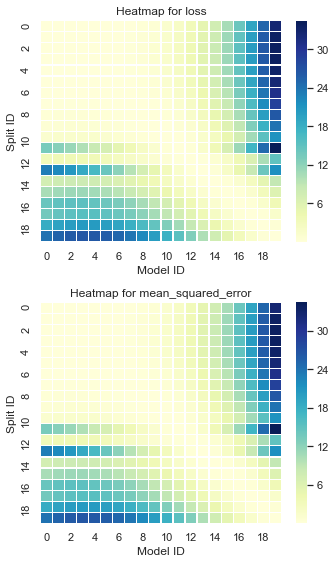

In [7]:
info = model_factory.get_metric_info()

num_metrics = len(info.keys())
fig, axs = plt.subplots(num_metrics, 1)
fig.set_size_inches(5, 8)
for i, (key, value) in enumerate(info.items()):
    plot_heatmap(matrix=value.matrix, title=f'Heatmap for {key}', 
                 x_label='Model ID', y_label='Split ID', ax=axs[i])
fig.tight_layout()

Note no plot acima que quanto mais distante da partição em que o modelo foi treinado, maior o erro que o modelo obtém na predição. Por exemplo, o modelo 19 obtém MSE de mais de 50 para partição 2 enquanto menor que 10 para partição 19.